In [1]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric


3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [109]:
!pip install keras-cv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.7 MB/s eta 0:00:003.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:008.0 MB/s eta 0:00:01
  DEPRECATION: Building 'promise' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'promise'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl si

In [133]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split



In [167]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)   


    def _normalize(self, train, val):
        scaler_cols = []
        for col_idx in range(train.shape[1]):
            scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
            train[:, col_idx] = remove_extra_dim(scaler.fit_transform(add_extra_dim(train[:, col_idx])))
            val[:, col_idx] = remove_extra_dim(scaler.transform(add_extra_dim(val[:, col_idx])))
            scaler_cols.append(scaler)
        self.scaler.append(scaler_cols)
        return train, val
    
    def _normalize_test(self, test):
        # Reuse scalers already fitted on train, assuming self.scaler is not empty.
        for col_idx in range(test.shape[1]):
            scaler = self.scaler[0][col_idx]  # Assuming first patient’s scaler; adjust logic as needed.
            test[:, col_idx] = remove_extra_dim(scaler.transform(add_extra_dim(test[:, col_idx])))
        return test

    def preprocessing_mimic(
        self,
        lst_train_arrays,
        lst_test_arrays,
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
    
        self.scaler = []  # reset for mimic-specific normalization
    
        # Split by patient index
        num_patients = len(lst_train_arrays)
        split_idx = int(train_size * num_patients)
    
        train_patients = lst_train_arrays[:split_idx]
        val_patients = lst_train_arrays[split_idx:]
    
        train_lst = []
        val_lst = []
        test_lst = []
    
        # Normalize train patients
        for bg_sample_train in train_patients:
            if self.normalize:
                scaler_cols = []
                for col_idx in range(bg_sample_train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    bg_sample_train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform(add_extra_dim(bg_sample_train[:, col_idx]))
                    )
                    scaler_cols.append(scaler)
                self.scaler.append(scaler_cols)
    
            train_lst.append(bg_sample_train)
    
        # Normalize val patients with train scalers
        for idx, bg_sample_val in enumerate(val_patients):
            if self.normalize and self.scaler:
                for col_idx in range(bg_sample_val.shape[1]):
                    scaler = self.scaler[0][col_idx]  # Reuse first train patient scaler
                    bg_sample_val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(bg_sample_val[:, col_idx]))
                    )
            val_lst.append(bg_sample_val)
    
        # Normalize test patients with train scalers
        for bg_sample_test in lst_test_arrays:
            if self.normalize and self.scaler:
                for col_idx in range(bg_sample_test.shape[1]):
                    scaler = self.scaler[0][col_idx]
                    bg_sample_test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(bg_sample_test[:, col_idx]))
                    )
            test_lst.append(bg_sample_test)
            
        self.historical_values = []
        for series in train_lst + val_lst + test_lst:
            lst_hist_values = []
            for col_idx in range(series.shape[1]):
                unique_values = np.unique(np.round(series[:, col_idx], decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)
    
        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )


In [4]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [42]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            #print("TETSTSETS", idx, cut, a_train, a_test)
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")

    elif dataset == "mimic":
        base_cluster_dir = data_path + "data_MIMIC/" + "cluster_csv"
        output_dir = data_path + "data_MIMIC/" + "combined_cluster_data"
        os.makedirs(output_dir, exist_ok=True)
    
        for cluster_id in ["0", "1", "2", "3"]:
            cluster_folder = f"cluster_{cluster_id}"
            cluster_path = os.path.join(base_cluster_dir, cluster_folder)
    
            if not os.path.isdir(cluster_path):
                print(f"Cluster folder {cluster_folder} not found.")
                continue
    
            print(f"Processing {cluster_folder}...")
    
            all_data = pd.DataFrame()
    
            for file_name in sorted(os.listdir(cluster_path)):
                if not file_name.endswith(".csv"):
                    continue
    
                file_path = os.path.join(cluster_path, file_name)
                df = pd.read_csv(file_path)
                subject_id = int(file_name.split("_")[1].replace(".csv", ""))
                df['patient_id'] = subject_id
                df['label_30d'] = df['label_30d'].astype(int)
                df['label_1y'] = df['label_1y'].astype(int)
    
                all_data = pd.concat([all_data, df], ignore_index=True)
    
            # Patient-level split for this cluster
            patient_ids = all_data['patient_id'].unique()
            train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
    
            train = all_data[all_data['patient_id'].isin(train_ids)]
            test = all_data[all_data['patient_id'].isin(test_ids)]
    
            train.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_train.csv"), index=False)
            test.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_test.csv"), index=False)
    
            print(f"Cluster {cluster_id}: {len(train_ids)} train patients, {len(test_ids)} test patients.")
            print(f"Files saved in {output_dir}")


In [83]:
def load_data(dataset, data_path, cluster_id):
    cluster_id = cluster_id
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(data_path, cluster_id, "_train.csv" )
        test, orig_test = load_mimic_data(data_path, cluster_id, "_test.csv")
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg

def load_mimic_data(data_path,  cluster_id, file_name = "_train.csv"):
    #data = pd.read_csv(data_path + "data_MIMIC/combined_cluster_data/" + "cluster_" + cluster_id + file_name)
    full_path = os.path.join(data_path, "data_MIMIC", "combined_cluster_data", f"cluster_{cluster_id}{file_name}")
    data = pd.read_csv(full_path)
    print("data", data)
    # Select relevant features for lst_arrays
    #feature_columns = [
    #    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    #    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    #    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
    #]
    
    feature_columns = [
        "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
        "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
        "WBC Count", "Sodium", "NT-proBNP", "Troponin T", "label_1y"#"label_30d",
    ]
    lst_arrays = []
    for patient_id, group in data.groupby("patient_id"):
        lst_arrays.append(group[feature_columns].to_numpy())


    return lst_arrays, data



In [25]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [168]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
parser.add_argument( "--cluster", type=str, default=0, help="Choose cluster for MIMIC data, default 0")
# Parse the arguments from a string
#args = parser.parse_args("--dataset ohiot1dm --horizon 3 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 5 --back-horizon 20 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper --cluster 0".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path, args.cluster) #misschien toch load_data gebruiken?
print(f"lst_arrays length: {len(lst_arrays)}")
for i, arr in enumerate(lst_arrays[:3]):  # Sample check
    print(f"lst_arrays[{i}] shape: {arr.shape}")


print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")


Processing cluster_0...
Cluster 0: 337 train patients, 85 test patients.
Files saved in ./data/data_MIMIC/combined_cluster_data
Processing cluster_1...
Cluster 1: 242 train patients, 61 test patients.
Files saved in ./data/data_MIMIC/combined_cluster_data
Processing cluster_2...
Cluster 2: 435 train patients, 109 test patients.
Files saved in ./data/data_MIMIC/combined_cluster_data
Processing cluster_3...
Cluster 3: 308 train patients, 78 test patients.
Files saved in ./data/data_MIMIC/combined_cluster_data
data       Heart Rate  Systolic BP  Diastolic BP    SpO2  Temperature        BMI  \
0        100.125       142.12        128.28   96.25        98.15  66.400000   
1         86.250       139.24        124.56   97.50        97.90  66.400000   
2         72.375       136.36        120.84   98.75        97.65  66.400000   
3         58.500       133.48        117.12  100.00        97.40  66.400000   
4         51.000       130.60        113.40  100.00        97.40  66.400000   
...     

In [169]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.math.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * tf.math.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

In [170]:
from sklearn.metrics import f1_score
import numpy as np

def find_best_threshold(y_true, y_pred_prob, positive_label=1):
    """
    Finds the threshold that maximizes F1-score for the specified positive class.

    Args:
        y_true (array-like): True binary labels (shape: [n_samples]).
        y_pred_prob (array-like): Predicted probabilities (shape: [n_samples]).
        positive_label (int): The label of the positive class (default: 1).

    Returns:
        best_threshold (float): Threshold value maximizing F1-score.
        best_f1 (float): Best F1-score achieved.
    """
    thresholds = np.linspace(0, 1, 101)
    best_threshold = 0.5
    best_f1 = 0.0

    for threshold in thresholds[1:-1]:  # Skip 0.0 and 1.0
        y_pred = (y_pred_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=positive_label)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


In [191]:
# parser = ArgumentParser()
# parser.add_argument( "--dataset", type=str, help="Choose dataset.")
# parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
# parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
# parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
# parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
# parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
# # Parse the arguments from a string
# #args = parser.parse_args("--dataset ohiot1dm --horizon 3 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args("--dataset simulated --horizon 5 --back-horizon 20 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args()
# data_path = "./data/"
# lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
# print(lst_arrays, orig_train)
# #print(lst_arrays, orig_train)
# print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
# print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

# print(f"===========Desired trend parameters=============")
# center = "last"
# desired_shift, poly_order = 0, 1
# fraction_std = 1#args.fraction_std
# print(f"center: {center}, desired_shift: {desired_shift};")
# print(f"fraction_std:{fraction_std};")
# print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated":
    CHANGE_COLS = [1, 2]
elif args.dataset == "mimic": #??? more
    CHANGE_COLS = list(range(14))  # 0-13 as exogenous
    TARGET_COL = 14  #or 15, 14:30d, 15:1y
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
if args.dataset == "mimic":
    dataset.preprocessing_mimic(
        lst_train_arrays=lst_arrays,
        lst_test_arrays=lst_arrays_test,
        train_size=TRAIN_SIZE,
        normalize=True,
        sequence_stride=1,
        target_col=TARGET_COL,
        exog_cols=CHANGE_COLS,
        horizon=horizon
    )
else:
    dataset.preprocessing(#???
        lst_train_arrays=lst_arrays,
        lst_test_arrays=lst_arrays_test,
        train_size=TRAIN_SIZE,
        normalize=True,
        sequence_stride= horizon,
        target_col=TARGET_COL,
        exog_cols=CHANGE_COLS,
        horizon = horizon
    )

print("X_train_exog shape:", dataset.X_train_exog.shape)
print("X_train_target shape:", dataset.X_train_target.shape)
print("Y_train shape:", dataset.Y_train.shape)


print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
y_test = dataset.Y_test
X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
y_val = dataset.Y_val
print("Test", X_train, y_train)
exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_exog_features = exog_train.shape[2]
print(n_in_features, n_exog_features)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
if args.dataset == "ohio":
    forecast_GRU = keras.Sequential([
        layers.Input(shape=(args.back_horizon, n_in_features)),
        layers.GRU(100, activation="tanh", return_sequences=True, dropout=0.3, recurrent_dropout=0.1),
        layers.GRU(100, activation="tanh", return_sequences=True, dropout=0.3, recurrent_dropout=0.1),
        layers.Bidirectional(layers.GRU(100, return_sequences=False)),
        layers.Dense(args.horizon * n_in_features, activation="sigmoid"),
        layers.Reshape((args.horizon, n_in_features))
    ])

    # forecast_GRU = keras.Sequential([
    #     layers.Input(shape=(args.back_horizon, n_in_features)),
    #     layers.GRU(100, activation="tanh", return_sequences=True),
    #     layers.GRU(100, activation="tanh", return_sequences=False),
    #     layers.Dense(args.horizon, activation="sigmoid"),  # Output horizon binary values
    #     layers.Reshape((args.horizon, 1))
    # ])

    class NBeatsBlock(layers.Layer):
        def __init__(self, units, horizon, **kwargs):
            super().__init__(**kwargs)
            self.fc1 = layers.Dense(units, activation="relu")
            self.fc2 = layers.Dense(units, activation="relu")
            #self.fc3 = layers.Dense(units, activation="relu")
            #self.fc4 = layers.Dense(units, activation="relu")
            self.norm = layers.LayerNormalization()
            self.backcast = layers.Dense(horizon * n_in_features, activation="sigmoid")  
            self.forecast = layers.Dense(horizon * n_in_features, activation="sigmoid") 
            
        def call(self, inputs):
            x = self.fc1(inputs)
            x = self.fc2(x)
            #x = self.fc3(x)
            #x = self.fc4(x)
            x = self.norm(x)
            return self.forecast(x)  # No reshape needed if predicting horizon x 1 directly

    def build_nbeats_model(back_horizon, n_in_features, horizon, units=128):
        inputs = keras.Input(shape=(back_horizon, n_in_features))
        x = layers.Flatten()(inputs)
        x = NBeatsBlock(units, horizon)(x)
        x = tf.reshape(x, (-1, horizon, 1))
        
        model = keras.Model(inputs, x)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",#focal_loss(alpha=0.25, gamma=2.0),
              metrics=[
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.Recall(name="accuracy")
              ])        
              #metrics=["accuracy"])
    
        #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      #loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
                      #metrics=["accuracy"])
                      #loss="binary_crossentropy",
                      #metrics=["accuracy"])
        return model
    
    TARGET_INDEX = 0  
    #y_train_binary = y_train[:, :, TARGET_INDEX].reshape((-1, args.horizon, 1))
    #y_val_binary = y_val[:, :, TARGET_INDEX].reshape((-1, args.horizon, 1))
    #y_test_binary = y_test[:, :, TARGET_INDEX].reshape((-1, args.horizon, 1))
    y_train_binary = y_train  # Shape: (num_samples, args.horizon, n_in_features)
    y_val_binary = y_val
    y_test_binary = y_test

    y_train_labels = y_train_binary.reshape(-1)
    unique_classes = np.unique(y_train_labels)
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                      classes=unique_classes,
                                                      y=y_train_labels)
    class_weights_dict = {label: weight for label, weight in zip(unique_classes, class_weights)}
    
    #weights = [class_weights_dict.get(0, 1.0), class_weights_dict.get(1, 1.0)]

    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    forecast_GRU.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
            # .compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            #   loss="binary_crossentropy",#focal_loss(alpha=0.25, gamma=2.0),
            #   metrics=[
            #     tf.keras.metrics.Precision(name="precision"),
            #     tf.keras.metrics.Recall(name="recall"),
            #     tf.keras.metrics.Recall(name="accuracy")
            #   ])

    #.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    #                  loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0))#, loss="mae")
    forecast_GRU.fit(X_train, y_train_binary, 
                     epochs=200, 
                     batch_size=64, 
                     validation_data=(X_val, y_val_binary), 
                     callbacks=[early_stopping],
                     class_weight=class_weights_dict)
    pred_all_GRU = forecast_GRU.predict(X_test)
    
    forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
    forecast_NBEATS.fit(X_train, y_train_binary,
                        epochs=200, 
                        batch_size=32, 
                        validation_data=(X_val, y_val_binary), 
                        callbacks=[early_stopping],
                        class_weight=class_weights_dict)
    pred_all_NBEATS = forecast_NBEATS.predict(X_test)

        
else:
    forecast_GRU = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=True), #200 testen
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
        tf.keras.layers.Reshape((horizon, n_in_features))
    ])

    # Define N-BEATS Block
    class NBeatsBlock(layers.Layer):
        def __init__(self, units, horizon, n_in_features, **kwargs):
            super(NBeatsBlock, self).__init__(**kwargs)
            self.fc1 = layers.Dense(units, activation="relu")
            self.fc2 = layers.Dense(units, activation="relu")
            self.fc3 = layers.Dense(units, activation="relu")
            self.fc4 = layers.Dense(units, activation="relu")
            self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
            self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  
    
        def call(self, inputs):
            x = self.fc1(inputs)
            x = self.fc2(x)
            x = self.fc3(x)
            x = self.fc4(x)
            backcast = self.backcast(x)
            forecast = self.forecast(x)
            return forecast
    
    def build_nbeats_model(back_horizon, n_in_features, horizon, units=512):
        inputs = keras.Input(shape=(back_horizon, n_in_features))
        x = layers.Flatten()(inputs)  # Flatten time series input
    
        # Stack multiple N-BEATS blocks
        x = NBeatsBlock(units, horizon, n_in_features)(x)
        x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape
    
        model = keras.Model(inputs, x)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
        return model

    forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
    #tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
    forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
    
    
    pred_all_GRU = forecast_GRU.predict(X_test)
    
    #elif args.forecast_model == "nbeatsx":
    forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
    forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
    pred_all_NBEATS = forecast_NBEATS.predict(X_test)




X_train_exog shape: (1614, 12, 14)
X_train_target shape: (1614, 12, 1)
Y_train shape: (1614, 6, 1)
Shape (1614, 12, 14) (1614, 12, 1) (1614, 6, 1) (510, 12, 14) (510, 12, 1)
Test [[[1.         1.         1.         ... 1.         0.38953488 0.        ]
  [0.77300613 0.95652174 0.95652174 ... 0.95652174 0.59302326 0.        ]
  [0.54601227 0.91304348 0.91304348 ... 0.91304348 0.79651163 0.        ]
  ...
  [0.34355828 0.60869565 0.60869565 ... 0.60869565 1.         0.        ]
  [0.34355828 0.56521739 0.56521739 ... 0.56521739 0.91666667 0.        ]
  [0.34355828 0.52173913 0.52173913 ... 0.52173913 0.83333333 0.        ]]

 [[0.77300613 0.95652174 0.95652174 ... 0.95652174 0.59302326 0.        ]
  [0.54601227 0.91304348 0.91304348 ... 0.91304348 0.79651163 0.        ]
  [0.3190184  0.86956522 0.86956522 ... 0.86956522 1.         0.        ]
  ...
  [0.34355828 0.56521739 0.56521739 ... 0.56521739 0.91666667 0.        ]
  [0.34355828 0.52173913 0.52173913 ... 0.52173913 0.83333333 0.   

2025-07-14 19:18:50.176179: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


25/26 [===========================>..] - ETA: 0s - loss: 0.0832

2025-07-14 19:19:00.820985: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


26/26 [==============================] - 13s 160ms/step - loss: 0.0830 - val_loss: 0.3713
Epoch 2/200
26/26 [==============================] - 2s 61ms/step - loss: 0.0489 - val_loss: 0.3608
Epoch 3/200
26/26 [==============================] - 2s 69ms/step - loss: 0.0355 - val_loss: 0.3532
Epoch 4/200
26/26 [==============================] - 2s 59ms/step - loss: 0.0280 - val_loss: 0.3449
Epoch 5/200
26/26 [==============================] - 2s 61ms/step - loss: 0.0231 - val_loss: 0.3373
Epoch 6/200
26/26 [==============================] - 2s 61ms/step - loss: 0.0193 - val_loss: 0.3298
Epoch 7/200
26/26 [==============================] - 1s 58ms/step - loss: 0.0164 - val_loss: 0.3221
Epoch 8/200
26/26 [==============================] - 2s 59ms/step - loss: 0.0140 - val_loss: 0.3146
Epoch 9/200
26/26 [==============================] - 1s 55ms/step - loss: 0.0120 - val_loss: 0.3075
Epoch 10/200
26/26 [==============================] - 2s 61ms/step - loss: 0.0104 - val_loss: 0.3005
Epoch 11/

2025-07-14 19:21:59.092271: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


16/16 [==============================] - 2s 16ms/step
Epoch 1/200
25/26 [===========================>..] - ETA: 0s - loss: 0.0421

2025-07-14 19:22:06.252607: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


26/26 [==============================] - 5s 57ms/step - loss: 0.0419 - val_loss: 4.5564
Epoch 2/200
26/26 [==============================] - 1s 34ms/step - loss: 0.0156 - val_loss: 3.3903
Epoch 3/200
26/26 [==============================] - 1s 35ms/step - loss: 0.0100 - val_loss: 2.8822
Epoch 4/200
26/26 [==============================] - 1s 35ms/step - loss: 0.0070 - val_loss: 2.4949
Epoch 5/200
26/26 [==============================] - 1s 34ms/step - loss: 0.0049 - val_loss: 2.1982
Epoch 6/200
26/26 [==============================] - 1s 35ms/step - loss: 0.0032 - val_loss: 1.9432
Epoch 7/200
26/26 [==============================] - 1s 35ms/step - loss: 0.0016 - val_loss: 1.6669
Epoch 8/200
26/26 [==============================] - 1s 37ms/step - loss: 3.3614e-04 - val_loss: 1.4964
Epoch 9/200
26/26 [==============================] - 1s 35ms/step - loss: 5.8928e-05 - val_loss: 1.4208
Epoch 10/200
26/26 [==============================] - 1s 33ms/step - loss: 3.1535e-05 - val_loss: 1.4007

2025-07-14 19:22:29.690454: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


16/16 [==============================] - 0s 7ms/step


In [192]:
import sklearn.metrics as metrics
from sklearn.metrics import balanced_accuracy_score, average_precision_score, brier_score_loss
print(pred_all_NBEATS.shape)
# Assuming y_test_binary and pred_tf_gru (probabilities) are already defined
#best_threshold_gru, best_f1_gru = find_best_threshold(y_test_binary.flatten(), pred_tf_gru.flatten())
#print(f"Best threshold for GRU: {best_threshold_gru:.2f}, Best F1-Score: {best_f1_gru:.4f}")
print("TETETET", np.percentile(pred_tf_gru.flatten(), [0, 25, 50, 75, 100]))

#best_threshold_nbeats, best_f1_nbeats = find_best_threshold(y_test_binary.flatten(), pred_tf_nbeats.flatten())
#print(f"Best threshold for NBEATS: {best_threshold_nbeats:.2f}, Best F1-Score: {best_f1_nbeats:.4f}")

# Extract binary predictions (assuming binary target is at index 0)
pred_tf_gru = pred_all_GRU[:, :, 0]
pred_tf_gru_binary = pred_tf_gru.astype(int)
pred_exog_gru = pred_all_GRU[:,:,1:]
#pred_tf_gru_binary = (pred_tf_gru >= best_threshold_gru).astype(int)
gru_probs = pred_tf_gru.flatten()
gru_preds = pred_tf_gru_binary.flatten()
true_labels = y_test_binary.flatten()

balanced_acc_gru = balanced_accuracy_score(true_labels, gru_preds)
pr_auc_gru = average_precision_score(true_labels, gru_probs)
brier_gru = brier_score_loss(true_labels, gru_probs)

print(f"GRU Model - Balanced Accuracy: {balanced_acc_gru:.4f}, PR AUC: {pr_auc_gru:.4f}, Brier Score: {brier_gru:.4f}")

pred_tf_nbeats = pred_all_NBEATS[:, :, 0]
pred_tf_nbeats_binary = pred_tf_nbeats.astype(int)
#pred_tf_nbeats_binary = (pred_tf_nbeats >= best_threshold_nbeats).astype(int)
nbeats_probs = pred_tf_nbeats.flatten()
nbeats_preds = pred_tf_nbeats_binary.flatten()
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]
balanced_acc_nbeats = balanced_accuracy_score(true_labels, nbeats_preds)
pr_auc_nbeats = average_precision_score(true_labels, nbeats_probs)
brier_nbeats = brier_score_loss(true_labels, nbeats_probs)

print(f"NBEATS Model - Balanced Accuracy: {balanced_acc_nbeats:.4f}, PR AUC: {pr_auc_nbeats:.4f}, Brier Score: {brier_nbeats:.4f}")

print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
print("Positive class ratio in y_test:", np.mean(y_test_binary))
print("Positive class ratio in GRU predictions:", np.mean(pred_tf_gru_binary))
print("Positive class ratio in NBEATS predictions:", np.mean(pred_tf_nbeats_binary))

# Convert y_test binary to shape (num_samples, horizon)
y_test_binary = dataset.Y_test[:, :, 0].astype(int)  # true binary labels

# Calculate classification metrics for GRU
accuracy_gru = metrics.accuracy_score(y_test_binary.flatten(), pred_tf_gru_binary.flatten())
#f1_gru = metrics.f1_score(y_test_binary.flatten(), pred_tf_gru_binary.flatten())
f1_gru = metrics.f1_score(y_test_binary.flatten(), pred_tf_gru_binary.flatten(), pos_label=1)

print(f"GRU Model - Accuracy: {accuracy_gru:.4f}, F1 Score: {f1_gru:.4f}")

# Calculate classification metrics for NBEATS
accuracy_nbeats = metrics.accuracy_score(y_test_binary.flatten(), pred_tf_nbeats_binary.flatten())
#f1_nbeats = metrics.f1_score(y_test_binary.flatten(), pred_tf_nbeats_binary.flatten())
f1_nbeats = metrics.f1_score(y_test_binary.flatten(), pred_tf_nbeats_binary.flatten(), pos_label=1)

print(f"NBEATS Model - Accuracy: {accuracy_nbeats:.4f}, F1 Score: {f1_nbeats:.4f}")
from sklearn.metrics import classification_report

print("GRU Model Classification Report:")
print(classification_report(y_test_binary.flatten(), pred_tf_gru_binary.flatten(), target_names=["Survived", "Died"]))

print("NBEATS Model Classification Report:")
print(classification_report(y_test_binary.flatten(), pred_tf_nbeats_binary.flatten(), target_names=["Survived", "Died"]))

def plot_binary_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.step(range(y_true.shape[1]), y_true[idx], label='Actual', color='blue', where='post')
        plt.step(range(y_pred.shape[1]), y_pred[idx], label='Predicted', color='orange', where='post')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Binary Label')
        plt.ylim(-0.1, 1.1)
        plt.legend()
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"plot_binary_predictions_{name}.png")
    plt.show()

# Plot binary predictions vs actuals
plot_binary_predictions(y_test_binary, pred_tf_gru_binary, "gru", title='GRU Model Binary Predictions vs Actual')
plot_binary_predictions(y_test_binary, pred_tf_nbeats_binary, "nbeats", title='NBEATS Model Binary Predictions vs Actual')


(510, 6, 15)
TETETET [2.36497217e-04 3.97576383e-04 5.68484393e-04 9.59992118e-04
 9.96071219e-01]


ValueError: y_prob contains values less than 0.

In [175]:
import numpy as np

# Simulated prediction probabilities (survival probability for binary target)
pred_all = pred_all_NBEATS  # Example: 1000 samples with survival probabilities
threshold = 0.5  # Example threshold for binary classification

print(f"=========== CF Generation Setup =============")
print(f"Non-survival probability threshold: {threshold}")

# Step 1: Event labeling based on prediction threshold
# If non-survival probability >= threshold → label = 1 (non-survival), else 0 (survival)
event_labels = np.where(pred_all >= threshold, 1, 0)

survival_indices = np.argwhere(event_labels == 0).reshape(-1)
non_survival_indices = np.argwhere(event_labels == 1).reshape(-1)

print(f"Survival indices shape: {survival_indices.shape}")
print(f"Non-survival indices shape: {non_survival_indices.shape}")

# Step 2: Select a subset for CF generation
rand_test_size = 100
test_group = "survival"  # or "survival"

if test_group == "survival":
    indices = survival_indices
elif test_group == "non-survival":
    indices = non_survival_indices
else:
    indices = np.arange(pred_all.shape[0])

np.random.seed(42)
if len(indices) >= rand_test_size:
    rand_test_idx = np.random.choice(indices, rand_test_size, replace=False)
else:
    rand_test_idx = indices

print(f"Generating CFs for {len(rand_test_idx)} samples in total, for {test_group} group...")

# Step 3: Define desired target probabilities
# For counterfactuals: non-survival → shift toward survival (label 0 → probability closer to 0.1)
desired_target_prob = 0.1 if test_group == "non-survival" else 0.9
desired_target_array = np.full((len(rand_test_idx),), desired_target_prob)

print(f"Desired target probabilities set to {desired_target_prob} for counterfactual generation.")

# Step 4: Preparing inputs
Exog_test = dataset.X_reg_exog[rand_test_idx]
Target_test = dataset.X_reg_target[rand_test_idx]

print("Exog_test shape:", Exog_test.shape)
print("Target_test shape:", Target_test.shape)

print(f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group...")

hist_inputs = []
print("dataset.historical_values length:", len(dataset.historical_values))
print("dataset.reg_idxs shape:", dataset.reg_idxs.shape)
print("rand_test_idx max:", rand_test_idx.max())
print("rand_test_idx min:", rand_test_idx.min())
print("dataset.reg_idxs max:", dataset.reg_idxs.max())
print("dataset.reg_idxs min:", dataset.reg_idxs.min())

for i in range(len(rand_test_idx)):
    if rand_test_idx[i] >= len(dataset.reg_idxs):
        print(f"Skipping index {i}, rand_test_idx out of reg_idxs range.")
        continue
    idx = dataset.reg_idxs[rand_test_idx[i]]
    if idx >= len(dataset.historical_values):
        print(f"Skipping index {i}, idx {idx} out of historical_values range.")
        continue
    hist_inputs.append(dataset.historical_values[idx])


=========== CF Generation Setup =============
Non-survival probability threshold: 0.5
Survival indices shape: (9150,)
Non-survival indices shape: (30,)
Generating CFs for 100 samples in total, for survival group...
Desired target probabilities set to 0.9 for counterfactual generation.
Exog_test shape: (100, 6, 14)
Target_test shape: (100, 6, 1)
Generating CFs for 100 samples in total, for hyper test group...
dataset.historical_values length: 422
dataset.reg_idxs shape: (510,)
rand_test_idx max: 505
rand_test_idx min: 0
dataset.reg_idxs max: 84
dataset.reg_idxs min: 0


In [183]:
import numpy as np
import tensorflow as tf
import statsmodels.api as sm

class TimeSeriesOptimizer:
    def __init__(self, method, dataset, pred_exog, pred_tf, rand_test_idx, back_horizon, horizon, target_col, change_cols, clip_ranges=None, hist_inputs=None):
        self.method = method  # 'sarimax', 'ols', 'gru', or 'nbeats'
        self.dataset = dataset
        self.pred_exog = pred_exog
        self.pred_tf = pred_tf
        self.rand_test_idx = rand_test_idx
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.TARGET_COL = target_col
        self.CHANGE_COLS = change_cols
        self.learning_rate = 0.001
        self.clip_range_inputs = clip_ranges
        self.hist_value_inputs = hist_inputs
        
        self.targets = None
        self.orig_targets = None
        self.transformed_targets = None
        self.transformed_orig_targets = None
        self.transformed_exogs = None
        self.transformed_orig_exogs = None
        self.orig_exogs = None
        self.exogs = None
        self.losses = None
        self.model = None
        self.optimizer = None

        self._init_method()

    def _init_method(self):
        if self.method == 'sarimax':
            pass
        elif self.method == 'ols':
            pass
        elif self.method == 'gru':
            self._init_gru_model()
        elif self.method == 'nbeats':
            self._init_nbeats_model()
        else:
            raise ValueError(f"Unknown method: {self.method}")

    def _init_gru_model(self):
        X = self.dataset.X_reg_exog
        y = self.dataset.X_reg_target[:, self.TARGET_COL]
        X_val = self.dataset.X_reg_val_exog
        y_val = self.dataset.X_reg_val_target[:, self.TARGET_COL]

        in_features = X.shape[2]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.horizon, in_features)),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=True),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=False),
            tf.keras.layers.Dense(self.horizon, activation='linear'),
            tf.keras.layers.Reshape((self.horizon, 1))
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, epsilon=1e-07)
        self.model.compile(optimizer=self.optimizer, loss='mae')
        self.model.fit(X, y, epochs=200, batch_size=64,
                       validation_data=(X_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)])

    def _init_nbeats_model(self):
        horizon = self.horizon

        class NBeatsBlock(tf.keras.layers.Layer):
            def __init__(self, units, horizon):
                super().__init__()
                self.fc1 = tf.keras.layers.Dense(units, activation='relu')
                self.fc2 = tf.keras.layers.Dense(units, activation='relu')
                self.fc3 = tf.keras.layers.Dense(units, activation='relu')
                self.fc4 = tf.keras.layers.Dense(units, activation='relu')
                self.forecast = tf.keras.layers.Dense(horizon)

            def call(self, inputs):
                x = self.fc1(inputs)
                x = self.fc2(x)
                x = self.fc3(x)
                x = self.fc4(x)
                return self.forecast(x)

        class DifferentiableNBeats(tf.keras.Model):
            def __init__(self, horizon, units=128):
                super().__init__()
                self.flatten = tf.keras.layers.Flatten()
                self.block = NBeatsBlock(units, horizon)

            def call(self, x):
                x = self.flatten(x)
                return self.block(x)

        self.model = DifferentiableNBeats(horizon=self.horizon, units=128)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mae')

    def compute_loss(self, pred):
        """
        Loss pushing prediction toward 1 (survival).
        """
        target = tf.ones_like(pred)  # want pred close to 1
        mse = tf.keras.losses.MeanSquaredError()
        return mse(target, pred)

    def compute_gradient_finite_difference(self, model, X_e, epsilon=1e-4):
        """
        Compute finite difference gradient of loss w.r.t input X_e,
        pushing prediction toward 1.
        """
        # Compute original prediction
        if self.method == 'sarimax':
            pred = model.forecast(self.horizon, start_params=model.params, exog=X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        elif self.method == 'ols':
            pred = model.predict(X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        else:
            raise ValueError("Finite difference gradient only for sarimax or ols")

        original_loss = self.compute_loss(pred)

        gradients = np.zeros_like(X_e.numpy())
        for i in range(X_e.shape[0]):
            X_e_perturbed = X_e.numpy().copy()
            X_e_perturbed[i] += epsilon

            if self.method == 'sarimax':
                pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
            elif self.method == 'ols':
                pred_perturbed = model.predict(X_e_perturbed)
            pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

            perturbed_loss = self.compute_loss(pred_perturbed)

            gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

        return gradients

    def optimize(self):
        length = len(self.rand_test_idx)
        self.targets = np.empty((length, self.horizon))
        self.orig_targets = np.empty((length, self.horizon))
        self.transformed_targets = np.empty((length, self.horizon))
        self.transformed_orig_targets = np.empty((length, self.horizon))
        self.transformed_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.transformed_orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.losses = np.empty(length)

        for idx_i, idx in enumerate(self.rand_test_idx):
            clip_ranges = self.clip_range_inputs[idx_i] if self.clip_range_inputs else None
            hist_values = self.hist_value_inputs[idx_i] if self.hist_value_inputs else None

            if self.method == 'sarimax':
                self._optimize_sarimax(idx, idx_i, clip_ranges, hist_values)
            elif self.method == 'ols':
                self._optimize_ols(idx, idx_i, clip_ranges, hist_values)
            elif self.method == 'gru':
                self._optimize_gru(idx_i)
            elif self.method == 'nbeats':
                self._optimize_nbeats(idx_i)
            else:
                raise ValueError(f"Unknown method: {self.method}")

    def _optimize_sarimax(self, sample_idx, loop_idx, clip_ranges, hist_values):
        X = self.dataset.X_reg_exog[sample_idx]
        y = self.dataset.X_reg_target[sample_idx][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[sample_idx]
        print(f"self.pred_exog shape: {self.pred_exog.shape}")
        print(f"pred_exog_sample shape: {pred_exog_sample.shape}")


        if clip_ranges:
            # Clip each dimension
            grad_X_e = tf.Variable(
                pred_exog_sample,
                dtype=tf.float32,
                constraint=lambda x: tf.clip_by_value(x, clip_ranges[0][0], clip_ranges[0][1])
            )
        else:
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)

        mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1, 0, 0))
        mod = mod.fit(disp=False)

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        max_iter = 100
        it = 0

        pred = mod.forecast(self.horizon, start_params=mod.params, exog=grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        # Optimize pushing prediction toward 1
        while tf.reduce_mean(pred) < 0.99 and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = mod.forecast(self.horizon, start_params=mod.params, exog=grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            it += 1

        self.targets[i] = pred.numpy()
        self.losses[i] = self.compute_loss(pred).numpy()

    def _optimize_ols(self, sample_idx, loop_idx, clip_ranges, hist_values):
        X = self.dataset.X_reg_exog[sample_idx]
        y = self.dataset.X_reg_target[sample_idx][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[sample_idx]

        if clip_ranges:
            grad_X_e = tf.Variable(
                pred_exog_sample,
                dtype=tf.float32,
                constraint=lambda x: tf.clip_by_value(x, clip_ranges[0][0], clip_ranges[0][1])
            )
        else:
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)

        mod = sm.OLS(endog=np.asarray(y), exog=np.asarray(X))
        mod = mod.fit()

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        max_iter = 100
        it = 0

        pred = mod.predict(grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        while tf.reduce_mean(pred) < 0.99 and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = mod.predict(grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            it += 1

        self.targets[i] = pred.numpy()
        self.losses[i] = self.compute_loss(pred).numpy()

    def _optimize_gru(self, i):
        grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)

        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]

        survival_threshold = 0.99

        if tf.reduce_mean(pred) >= survival_threshold:
            self.targets[i] = pred.numpy()
            self.losses[i] = 0
            return

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        max_iter = 100
        it = 0

        while tf.reduce_mean(pred) < survival_threshold and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]
                loss = self.compute_loss(pred)
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
            it += 1

        self.targets[i] = pred.numpy()
        self.losses[i] = loss.numpy()

    def _optimize_nbeats(self, i):
        grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)

        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]

        survival_threshold = 0.99

        if tf.reduce_mean(pred) >= survival_threshold:
            self.targets[i] = pred.numpy()
            self.losses[i] = 0
            return

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        max_iter = 100
        it = 0

        while tf.reduce_mean(pred) < survival_threshold and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]
                loss = self.compute_loss(pred)
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
            it += 1

        self.targets[i] = pred.numpy()
        self.losses[i] = loss.numpy()


In [185]:
#print(pred_exog, pred_exog.shape)
X_test = np.concatenate((Target_test, Exog_test), axis=2)
pred_exog = pred_exog_nbeats
print(pred_exog)
clip_ranges = [[[0.0, 1.0]] * 5] * len(X_test)
opt = TimeSeriesOptimizer(
    method='sarimax',
    dataset=dataset,
    pred_exog=pred_exog,
    pred_tf=None,            # or your tensor if needed
    rand_test_idx=rand_test_idx,
    back_horizon=back_horizon,
    horizon=horizon,
    target_col=0,
    change_cols=CHANGE_COLS,
    clip_ranges=clip_ranges,  # can be None
    hist_inputs=hist_inputs   # can be None
)

opt.optimize()

mimic_targets_sarimax = opt.targets
mimic_losses = opt.losses


[]
self.pred_exog shape: (510, 6, 0)
pred_exog_sample shape: (6, 0)


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Provided exogenous values are not of the appropriate shape. Required (6, 14), got (6, 0).

In [ ]:
#Glucose

TESTTESTESTESTESTEST: (510, 6, 15) (510, 6, 15)
gru model trained, with test sMAPE score 197.8603; test RMSE score: 0.3655.
nbeats model trained, with test sMAPE score 194.9100; test RMSE score: 2.3495.
TEST (510, 6) (510, 6)


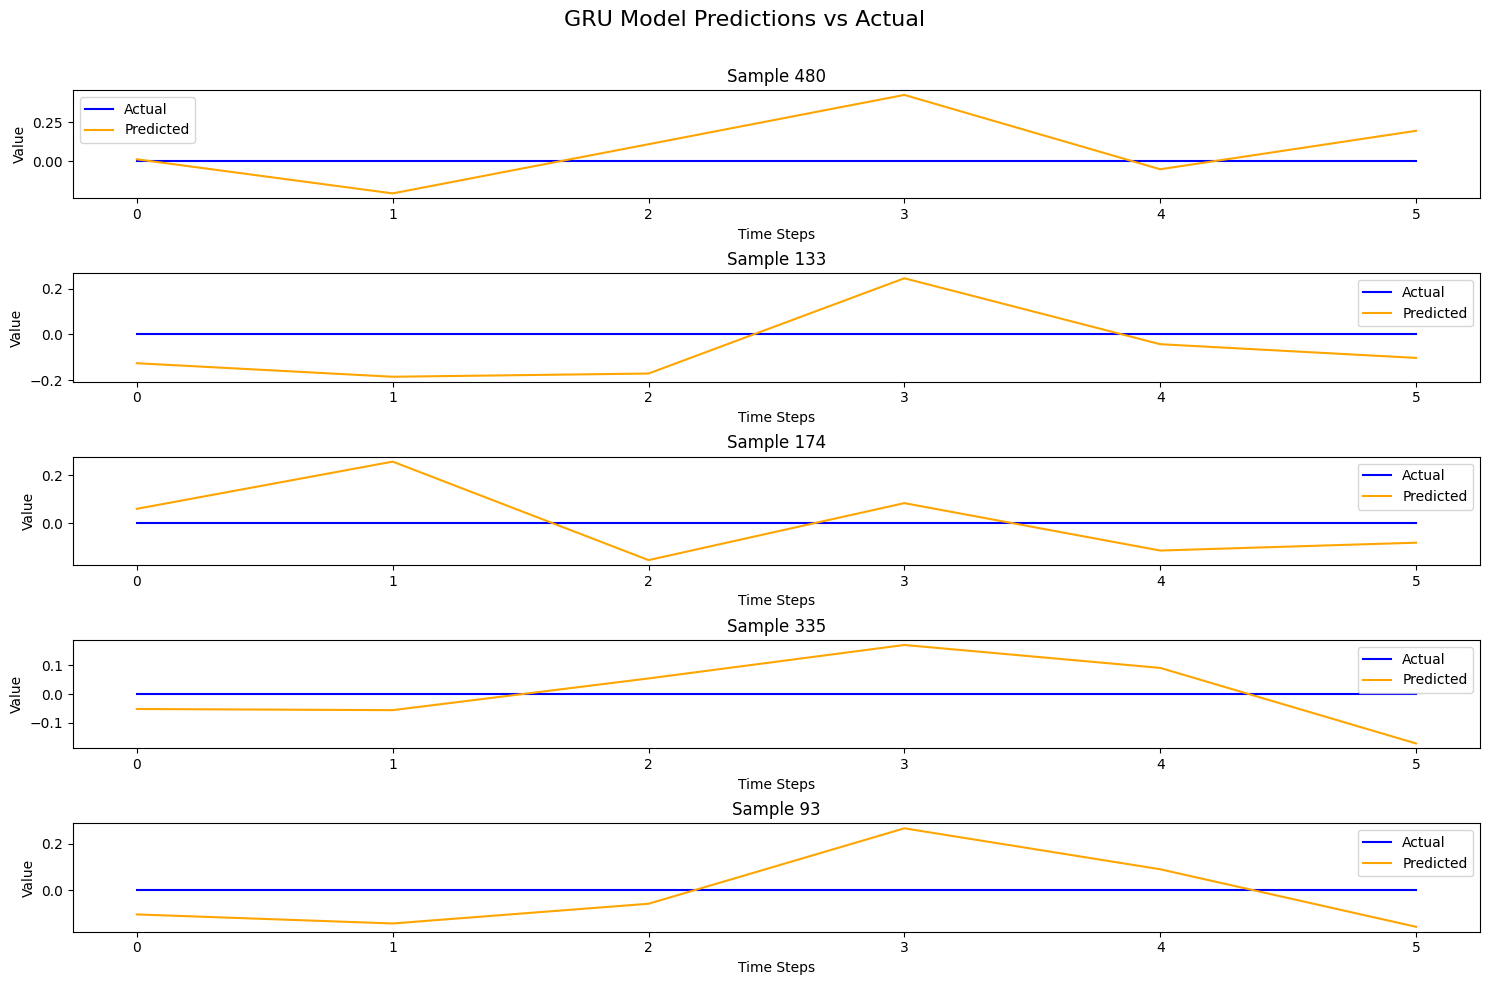

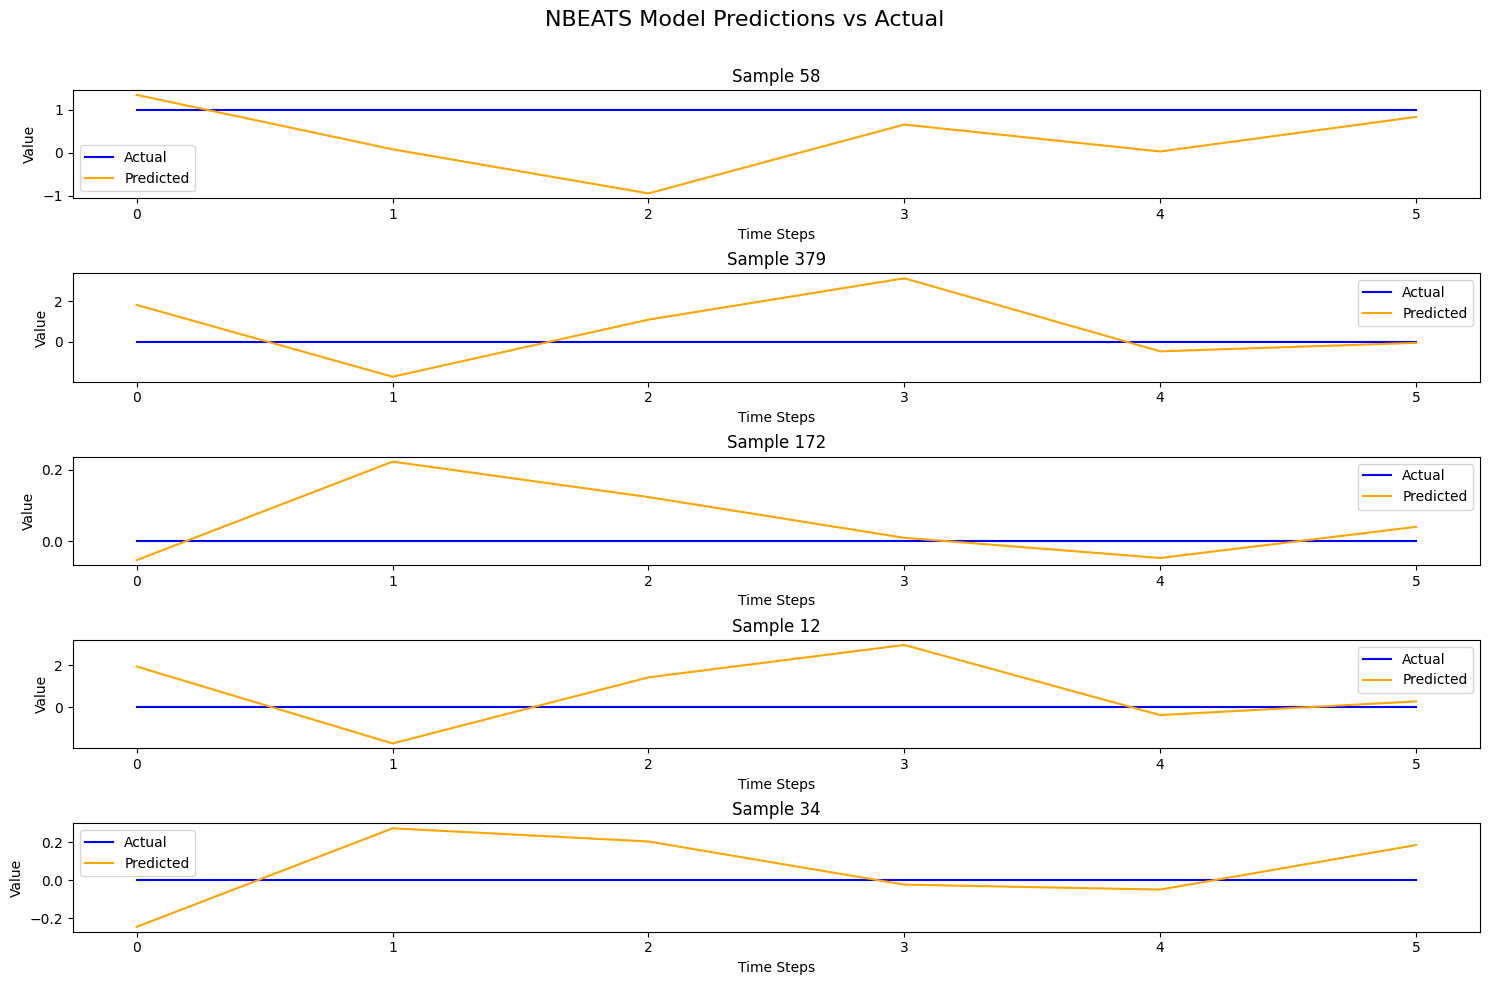

In [193]:

print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]

mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)

def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()


pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
